# Data Prep & Modeling
## Filtering

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

marte_raw = pd.read_csv('marte_vs_nlwest_19_22.csv',
                        usecols=['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'pitcher', 'zone', 'des', 'p_throws', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'iso_value', 'launch_speed_angle', 'pitch_name'])

# rename the primary response variable
marte_raw.rename(columns={'estimated_woba_using_speedangle': 'xwOBA'}, inplace=True)
print(f"data-set shape prior to filtering: {marte_raw.shape}")

# filter sacrifice events; if woba_denom is NaN, then sacrifice event
# filter walks and strikeout events
marte_raw.dropna(axis='rows', subset=['woba_denom', 'xwOBA'], how='any', inplace=True)
print(f"data-set shape after to filtering sac hits, walks, strikeouts: {marte_raw.shape}")

# filter missing observation data
marte_raw.dropna(axis='rows', subset=['release_spin_rate'], how='any', inplace=True)
print(f"data-set shape after to filtering missing spin observations: {marte_raw.shape}")

data-set shape prior to filtering: (867, 29)
data-set shape after to filtering sac hits, walks, strikeouts: (681, 29)
data-set shape after to filtering missing spin observations: (675, 29)


- release_speed
    - Pitch velocities from 2008-16 are via Pitch F/X, and adjusted to roughly out-of-hand release point. All velocities from 2017 and beyond are Statcast, which are reported out-of-hand.
- release_pos_x
    - horizontal Release Position of the ball measured in feet from the catcher's perspective.
- release_pos_z
    - Vertical Release Position of the ball measured in feet from the catcher's perspective.
- plate_x
    - Horizontal position of the ball when it crosses home plate from the catcher's perspective.
- plate_z
    - Vertical position of the ball when it crosses home plate from the catcher's perspective.
- pitcher
    - MLB Player Id tied to the play event.
- zone
    - Zone location of the ball when it crosses the plate from the catcher's perspective.
- pfx_x
    - Horizontal movement in feet from the catcher's perspective.
- pfx_z
    - Vertical movement in feet from the catcher's perpsective.
- effective_speed
    - Derived speed based on the the extension of the pitcher's release.
- release_spin
    - Spin rate of pitch tracked by Statcast.
- spin_axis
    - The Spin Axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball

## Filtering ext., Computed Features, NaN Conversions

In [7]:
import numpy as np
import math

# filter raw set with proposed model metrics
marte_vs = marte_raw.drop(columns=['woba_value','game_year', 'pitcher', 'game_date', 'release_pos_x', 'release_pos_z', 'des', 'bb_type', 'balls', 'strikes', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_extension', 'woba_denom', 'iso_value', 'launch_speed_angle', 'pitch_name'])
print(f"new data-set shape after to filtering for proper metrics: {marte_vs.shape}")

# vectorize the horizontal & vertical movement using pythagorean theorem
marte_vs['pfx_v'] = np.sqrt(marte_vs.pfx_x ** 2 + marte_vs.pfx_z ** 2)

print(f"number of NaN xwOBA PAs prior to conversion: {marte_vs.xwOBA.isnull().sum()}")

# if you do not filter walks and strikeouts from the raw data, this will allow more granular filtering
################################################################
# # if the xwOBA stat is NaN & a strikeout, then need to use the woba_value
# marte_vs['xwOBA'] = marte_vs.apply(lambda x: x.woba_value if (math.isnan(x.xwOBA) and x.woba_value == 0.0) else x.xwOBA, axis=1)
#
# # filter out walks, dropped 54 walks
# marte_vs.dropna(axis='rows', subset=['xwOBA'], how='any', inplace=True)
# print(f"data-set shape after to filtering walks: {marte_vs.shape}")
##########################################################

# reorder columns for logical readability
marte_vs = marte_vs.reindex(columns=['xwOBA', 'p_throws', 'pitch_type', 'release_speed', 'release_spin_rate', 'zone', 'pfx_x', 'pfx_z', 'pfx_v'])

print(marte_vs.head())

new data-set shape after to filtering for proper metrics: (675, 8)
number of NaN xwOBA PAs prior to conversion: 0
   xwOBA p_throws pitch_type  release_speed  release_spin_rate  zone  pfx_x  \
0  0.709        R         SI           92.9             2303.0     5  -1.15   
1  0.262        R         SI           92.6             2316.0     9  -1.05   
2  0.231        R         SI           93.0             2245.0     8  -1.13   
3  0.117        L         SI           93.3             2189.0     8   1.19   
4  0.438        R         SI           94.1             2126.0     4  -1.34   

   pfx_z     pfx_v  
0   0.68  1.336001  
1   0.80  1.320038  
2   0.79  1.378768  
3   0.28  1.222497  
4   0.45  1.413542  


## Transformations
### Dummies
A common mistake is to apply transformations to the entire data before splitting into training and test sets. This will bias the model evaluation because information would have leaked from the test set to the training set.

In [8]:
marte_vs_trx = pd.get_dummies(data=marte_vs, columns=['pitch_type', 'zone'])
marte_vs_trx = pd.get_dummies(data=marte_vs_trx, columns=['p_throws'], drop_first=True)
marte_vs_trx.head()

,xwOBA,release_speed,release_spin_rate,pfx_x,pfx_z,pfx_v,pitch_type_CH,pitch_type_CU,pitch_type_FC,pitch_type_FF,...,zone_5,zone_6,zone_7,zone_8,zone_9,zone_11,zone_12,zone_13,zone_14,p_throws_R
0,0.709,92.9,2303.0,-1.15,0.68,1.336001,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0.262,92.6,2316.0,-1.05,0.80,1.320038,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.231,93.0,2245.0,-1.13,0.79,1.378768,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.117,93.3,2189.0,1.19,0.28,1.222497,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0.438,94.1,2126.0,-1.34,0.45,1.413542,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Feature and output transformations

In [9]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

X = marte_vs_trx.drop(columns=['xwOBA'])  # remove response var and extra features, spin_axis should be converted to categorical if desired to use in analysis, removed earlier on ingest

y = marte_vs.xwOBA
# split data into training and testing sets

X = sm.add_constant(X)   # only needed for sm (not smf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1642)

print('Train set shape\n', X_train.shape, y_train.shape)
print('Test set shape\n', X_test.shape, y_test.shape)
print('---')

# transform numerical data
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

num_feats = ['release_speed', 'release_spin_rate', 'pfx_v', 'pfx_x', 'pfx_z']
# print(X[num_feats].describe())
# used for positive values
pt = PowerTransformer()
# get a transformed series of numerical features
X_train_trx = pt.fit_transform(X_train[num_feats])
# overwrite raw numerical data
X_train[num_feats] = X_train_trx

# transform the test set with the trained lambdas
X_test_trx = pt.transform(X_test[num_feats])
# overwrite raw numerical dataframe
X_test[num_feats] = X_test_trx
############################
# # normalize output
# mms = MinMaxScaler().fit(y_train.to_numpy().reshape(-1, 1))
# y_train_trx = pd.Series(map(lambda x: x[0], mms.transform(y_train.to_numpy().reshape(-1, 1))), index=y_train.index)
# # normalize on the test output, converted to a pandas.Series with the original indicies
# y_test_trx = pd.Series(map(lambda x: x[0], mms.transform(y_test.to_numpy().reshape(-1, 1))), index=y_test.index)

print('Train trx set shape\n', X_train_trx.shape, y_train.shape)
print('Test trx set shape\n', X_test_trx.shape, y_test.shape)
print('---')

Train set shape
 (438, 28) (438,)
Test set shape
 (237, 28) (237,)
---
Train trx set shape
 (438, 5) (438,)
Test trx set shape
 (237, 5) (237,)
---


## Modeling
### Naive Model
*Note: did not transform the output for the naive model.

In [10]:
# Marte's xwOBA for last 4 seasons ('19-'22) == .348 || without walks xwOBA == .305
from sklearn.metrics import *

print(y.mean())
y_same_xwOBA = pd.Series(.365, index=range(0, y_train.size))
# if squared is false then rmse
naive_rmse = mean_squared_error(y_true=y_train, y_pred=y_same_xwOBA, squared=False)
print(f"naive mse: {naive_rmse}")

naive_r2 = r2_score(y_true=y_train, y_pred=y_same_xwOBA)
print(f"naive r2 score: {naive_r2}")

0.36489185185185186
naive mse: 0.36604190443047196
naive r2 score: -0.0003866610950109539


### NN
#### Model 1

In [36]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow_addons.metrics import RSquare



# normalizer = preprocessing.Normalization()
# normalizer.adapt(np.array(train_features))
X_1 = X_train.release_spin_rate
X_1_test = X_test.release_spin_rate
number_of_inputs = 1  # number of features
model = keras.Sequential([layers.Dense(3, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(3, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

print("Fit model on training data")
history = model.fit(
    X_1,
    y_train,
    batch_size=42,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_1_test, y_test),
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_1_test, y_test, batch_size=30)
print("test loss, test acc:", results)

print("Generate predictions for test data")
predictions = model.predict(X_1_test)
print("predictions shape:", predictions.shape)

X1_rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)
print(f"rmse: {X1_rmse}")

X1_r2 = r2_score(y_true=y_test, y_pred=predictions)
print(f"r2 score: {X1_r2}")

Fit model on training data
Epoch 1/100
11/11 [==============================] - 1s 20ms/step - loss: 0.2478 - root_mean_squared_error: 0.4977 - mean_absolute_error: 0.3555 - r_square: -0.8498 - val_loss: 0.2411 - val_root_mean_squared_error: 0.4910 - val_mean_absolute_error: 0.3561 - val_r_square: -0.8629
Epoch 2/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2280 - root_mean_squared_error: 0.4775 - mean_absolute_error: 0.3359 - r_square: -0.7023 - val_loss: 0.2201 - val_root_mean_squared_error: 0.4692 - val_mean_absolute_error: 0.3362 - val_r_square: -0.7007
Epoch 3/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2080 - root_mean_squared_error: 0.4561 - mean_absolute_error: 0.3173 - r_square: -0.5529 - val_loss: 0.1999 - val_root_mean_squared_error: 0.4472 - val_mean_absolute_error: 0.3169 - val_r_square: -0.5448
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.1902 - root_mean_squared_error: 0.4361 - mean_absolute_error

#### NN2 -- Higher Fidelity Model

In [37]:

X_feats2 = ['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z', 'pfx_v', 'pitch_type_CH', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL', 'zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12', 'zone_13', 'zone_14', 'p_throws_R']
X_full = X_train[X_feats2]
X_full_test = X_test[X_feats2]
number_of_inputs = X_full.shape[1]  # number of features
model = keras.Sequential([layers.Dense(3, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(3, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train,
    batch_size=42,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test),
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test, batch_size=26)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for test samples")
X2_predictions = model.predict(X_full_test)
print("predictions shape:", predictions.shape)

X2_rmse = mean_squared_error(y_true=y_test, y_pred=X2_predictions, squared=False)
print(f"rmse: {X2_rmse}")

X2_r2 = r2_score(y_true=y_test, y_pred=X2_predictions)
print(f"r2 score: {X2_r2}")

Fit model on training data
Epoch 1/100
11/11 [==============================] - 1s 25ms/step - loss: 0.2859 - root_mean_squared_error: 0.5347 - mean_absolute_error: 0.3892 - r_square: -1.1344 - val_loss: 0.2927 - val_root_mean_squared_error: 0.5410 - val_mean_absolute_error: 0.4010 - val_r_square: -1.2610
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.2699 - root_mean_squared_error: 0.5195 - mean_absolute_error: 0.3692 - r_square: -1.0151 - val_loss: 0.2761 - val_root_mean_squared_error: 0.5255 - val_mean_absolute_error: 0.3825 - val_r_square: -1.1335
Epoch 3/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2564 - root_mean_squared_error: 0.5063 - mean_absolute_error: 0.3517 - r_square: -0.9142 - val_loss: 0.2616 - val_root_mean_squared_error: 0.5114 - val_mean_absolute_error: 0.3660 - val_r_square: -1.0209
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2441 - root_mean_squared_error: 0.4941 - mean_absolute_error

In [38]:
from tensorflow.keras import regularizers

X_feats3 = ['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z', 'pfx_v', 'pitch_type_CH', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL']
X_full = X_train[X_feats3]
X_full_test = X_test[X_feats3]
number_of_inputs = X_full.shape[1]  # number of features
model = keras.Sequential([layers.Dense(3, activation='relu', kernel_regularizer=regularizers.l1_l2(), input_dim=number_of_inputs),
                          layers.Dense(3, activation='relu', kernel_regularizer=regularizers.l1_l2()),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train,
    batch_size=42,
    epochs=400,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test),
    callbacks=[callback]
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test, batch_size=32)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for test samples")
X3_predictions = model.predict(X_full_test[X_feats3])
print("predictions shape:", predictions.shape)

X3_rmse = mean_squared_error(y_true=y_test, y_pred=X3_predictions, squared=False)
print(f"rmse: {X3_rmse}")

X3_r2 = r2_score(y_true=y_test, y_pred=X3_predictions)
print(f"r2 score: {X3_r2}")

Fit model on training data
Epoch 1/400
11/11 [==============================] - 1s 38ms/step - loss: 0.4964 - root_mean_squared_error: 0.5107 - mean_absolute_error: 0.3598 - r_square: -0.9470 - val_loss: 0.5006 - val_root_mean_squared_error: 0.5189 - val_mean_absolute_error: 0.3710 - val_r_square: -1.0800
Epoch 2/400
11/11 [==============================] - 0s 4ms/step - loss: 0.4769 - root_mean_squared_error: 0.4987 - mean_absolute_error: 0.3449 - r_square: -0.8567 - val_loss: 0.4800 - val_root_mean_squared_error: 0.5059 - val_mean_absolute_error: 0.3577 - val_r_square: -0.9774
Epoch 3/400
11/11 [==============================] - 0s 4ms/step - loss: 0.4581 - root_mean_squared_error: 0.4870 - mean_absolute_error: 0.3315 - r_square: -0.7707 - val_loss: 0.4603 - val_root_mean_squared_error: 0.4935 - val_mean_absolute_error: 0.3456 - val_r_square: -0.8817
Epoch 4/400
11/11 [==============================] - 0s 4ms/step - loss: 0.4404 - root_mean_squared_error: 0.4762 - mean_absolute_error

#### Hyper sweep

/var/folders/nz/57m0v30s0kqdtdm5876x20qw0000gn/T/ipykernel_35926/3098701642.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)
2022-12-04 22:04:06.199066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 22:04:06.248003: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with 

3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 1ms/step


3/3 [==============================] - 0s 1ms/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 1ms/step


3/3 [==============================] - 0s 18ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 1ms/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 693us/step


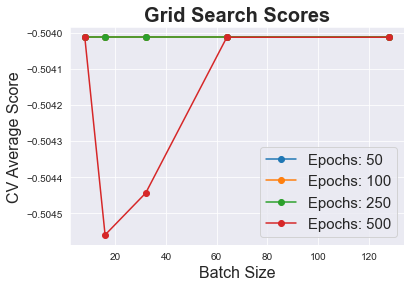

In [54]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_and_compile_model():
    # create model
    model = keras.Sequential([layers.Dense(3, activation='relu', input_dim=number_of_inputs),
                              layers.Dense(3, activation='relu'),
                              layers.Dense(1, activation='linear')]) # output layer for regression

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
    return model

model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)

# define the grid search parameters
batch_size = [8, 16, 32, 64, 128]
epochs = [50, 100, 250, 500]

param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)

grid_result = grid.fit(X_full, y_train)

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method
plot_grid_search(grid_result.cv_results_, batch_size, epochs, 'Batch Size', 'Epochs')

In [55]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

params = grid_result.cv_results_['params']

for mean, param in zip(means, params):
    print("train accuracy %f for: %r" % (mean, param))

Best: -0.504013 using {'batch_size': 8, 'epochs': 50}
train accuracy -0.504013 for: {'batch_size': 8, 'epochs': 50}
train accuracy -0.504013 for: {'batch_size': 8, 'epochs': 100}
train accuracy -0.504013 for: {'batch_size': 8, 'epochs': 250}
train accuracy -0.504013 for: {'batch_size': 8, 'epochs': 500}
train accuracy -0.504013 for: {'batch_size': 16, 'epochs': 50}
train accuracy -0.504013 for: {'batch_size': 16, 'epochs': 100}
train accuracy -0.504013 for: {'batch_size': 16, 'epochs': 250}
train accuracy -0.504013 for: {'batch_size': 16, 'epochs': 500}
train accuracy -0.504013 for: {'batch_size': 32, 'epochs': 50}
train accuracy -0.504013 for: {'batch_size': 32, 'epochs': 100}
train accuracy -0.504013 for: {'batch_size': 32, 'epochs': 250}
train accuracy -0.504013 for: {'batch_size': 32, 'epochs': 500}
train accuracy -0.504013 for: {'batch_size': 64, 'epochs': 50}
train accuracy -0.504013 for: {'batch_size': 64, 'epochs': 100}
train accuracy -0.504013 for: {'batch_size': 64, 'epochs':

In [56]:
def create_and_compile_model(num_neurons, num_layers):
    # create model
    model = keras.Sequential()
    model.add(Dense(num_neurons, input_dim=number_of_inputs, activation='relu'))

    if num_layers > 0:
        while num_layers > 0:
            model.add(Dense(num_neurons, activation='relu'))
            num_layers=num_layers-1

    model.add(Dense(1, activation='linear')) # output layer for regression

    # Compile model
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

    print(model.summary())
    print('--')

    return model

model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)

# define the grid search parameters
num_neurons_grid = [2, 3, 4, 5, 8, 10, 16]
num_layers_grid = [1, 2, 3, 4]

param_grid = dict(num_neurons=num_neurons_grid, num_layers=num_layers_grid)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)

grid_result = grid.fit(X_full, y_train)

/var/folders/nz/57m0v30s0kqdtdm5876x20qw0000gn/T/ipykernel_35926/3178102371.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 2)                 28        
                                                                 
 dense_28 (Dense)            (None, 2)                 6         
                                                                 
 dense_29 (Dense)            (None, 1)                 3         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 3)                 42        
                                                                 
 dense_34 (Dense)            (None,

Best: -0.505597 using {'num_layers': 2, 'num_neurons': 10}
train accuracy -0.505992 for: {'num_layers': 1, 'num_neurons': 2}
train accuracy -0.505923 for: {'num_layers': 1, 'num_neurons': 3}
train accuracy -0.505941 for: {'num_layers': 1, 'num_neurons': 4}
train accuracy -0.505725 for: {'num_layers': 1, 'num_neurons': 5}
train accuracy -0.505754 for: {'num_layers': 1, 'num_neurons': 8}
train accuracy -0.505930 for: {'num_layers': 1, 'num_neurons': 10}
train accuracy -0.505672 for: {'num_layers': 1, 'num_neurons': 16}
train accuracy -0.505985 for: {'num_layers': 2, 'num_neurons': 2}
train accuracy -0.506109 for: {'num_layers': 2, 'num_neurons': 3}
train accuracy -0.505863 for: {'num_layers': 2, 'num_neurons': 4}
train accuracy -0.506079 for: {'num_layers': 2, 'num_neurons': 5}
train accuracy -0.506040 for: {'num_layers': 2, 'num_neurons': 8}
train accuracy -0.505597 for: {'num_layers': 2, 'num_neurons': 10}
train accuracy -0.506082 for: {'num_layers': 2, 'num_neurons': 16}
train accurac

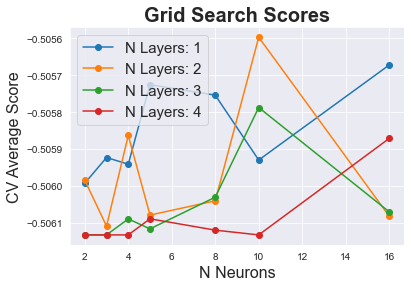

In [57]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method
plot_grid_search(grid_result.cv_results_, num_neurons_grid, num_layers_grid, 'N Neurons', 'N Layers')

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

params = grid_result.cv_results_['params']

for mean, param in zip(means, params):
    print("train accuracy %f for: %r" % (mean, param))

#### Combining Sweep

In [79]:
model = keras.Sequential([layers.Dense(10, activation='relu', input_dim=number_of_inputs, kernel_regularizer=regularizers.l1_l2()),
                          layers.Dense(10, activation='sigmoid', kernel_regularizer=regularizers.l1_l2()),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train,
    batch_size=8,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test),
    callbacks=[callback],
    verbose=0
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test, batch_size=8)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions")
predictions = model.predict(X_full_test)
print("predictions shape:", predictions.shape)

X4_rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)
print(f"rmse: {X4_rmse}")

X4_r2 = r2_score(y_true=y_test, y_pred=predictions)
print(f"r2 score: {X4_r2}")

Fit model on training data
Evaluate on test data
30/30 [==============================] - 0s 721us/step - loss: 0.1910 - root_mean_squared_error: 0.3605 - mean_absolute_error: 0.2773 - r_square: -0.0041
test loss, test acc: [0.19096574187278748, 0.36051344871520996, 0.277291476726532, -0.0041457414627075195]
Generate predictions
8/8 [==============================] - 0s 780us/step
predictions shape: (237, 1)
rmse: 0.36051343808317454
r2 score: -0.004145088062937008


TW NN

# of inputs = 28


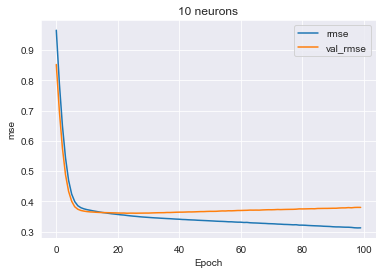

14/14 [==============================] - 0s 697us/step
MAE Train = 0.2377029588115678
RMSE Train = 0.31032090310796634
R2  = 0.28100090973738356

8/8 [==============================] - 0s 946us/step
MAE Test = 0.29115884621887766
RMSE Test = 0.3799462889206785
R2  = -0.11531608817334726


In [89]:
# Define the loss plot
def plot_loss(history, num_neurons):
    plt.plot(history.history['root_mean_squared_error'], label='rmse')
    plt.plot(history.history['val_root_mean_squared_error'], label='val_rmse')
    # plt.ylim([0, y_lim])
    plt.xlabel('Epoch')
    plt.ylabel('mse')
    plt.legend()
    plt.title(f"{num_neurons} neurons")

    plt.grid(True)
    plt.show()

from   tensorflow.keras import layers, regularizers
from   tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
from   tensorflow.keras.optimizers import Adam

#setup normalizer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

number_of_inputs= X_train.shape[1]
print(f"# of inputs = {number_of_inputs}")

num_neurons = 10

# create model
model = keras.Sequential([normalizer,
                          layers.Dense(num_neurons, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(num_neurons, activation='sigmoid'),
                          layers.Dense(1, activation='linear') ])  
  
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

history = model.fit(X_train, 
                    y_train,
                    batch_size=20,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    verbose=0)  # Calculate validation results on 35% of the training data
                  
# Isolate and plot training curves 
hist = pd.DataFrame(history.history)
plot_loss(history, num_neurons)

# calculate metrics ---------------
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# train
y_pred = model.predict(X_train)
print(f"MAE Train = {mean_absolute_error(y_train, y_pred)}")
print(f"RMSE Train = {mean_squared_error(y_train, y_pred, squared=False)}")
print(f"R2  = {                 r2_score(y_train, y_pred)}")
print(f"")

# holdout
y_pred = model.predict(X_test)
print(f"MAE Test = {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE Test = {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R2  = {                r2_score(y_test, y_pred)}")

TW NN neurons sweep

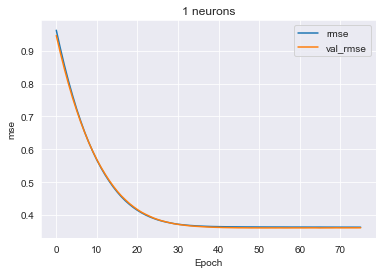

14/14 [==============================] - 0s 673us/step
MAE Train =     0.28242502868937575
RMSE Train =    0.36328847371972206
R2 =            0.014606897981671363

8/8 [==============================] - 0s 781us/step
MAE Test =      0.2779739211440589
RMSE Test =     0.3616207870647491
R2 =            -0.010323203121306967


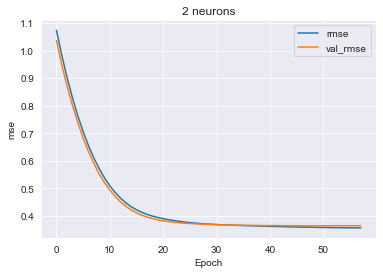

14/14 [==============================] - 0s 739us/step
MAE Train =     0.2722227030007262
RMSE Train =    0.35599591316000856
R2 =            0.053770890381936276

8/8 [==============================] - 0s 807us/step
MAE Test =      0.2821329283010104
RMSE Test =     0.36457100849922325
R2 =            -0.026875547176056225


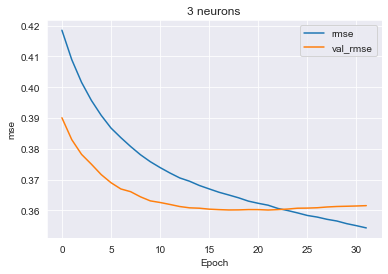

14/14 [==============================] - 0s 740us/step
MAE Train =     0.27147768688528506
RMSE Train =    0.3535819109234174
R2 =            0.06656010815023328

8/8 [==============================] - 0s 794us/step
MAE Test =      0.2770687449320459
RMSE Test =     0.36153247864291177
R2 =            -0.009829818023108894


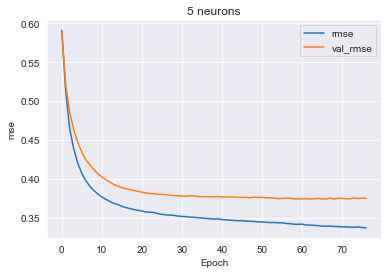

14/14 [==============================] - 0s 727us/step
MAE Train =     0.2543548452900425
RMSE Train =    0.3353708842465618
R2 =            0.16023650481502993

8/8 [==============================] - 0s 990us/step
MAE Test =      0.2856700583017324
RMSE Test =     0.3745908583079878
R2 =            -0.0840963989572221


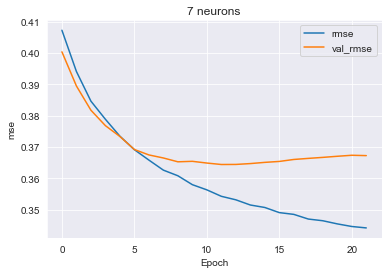

14/14 [==============================] - 0s 776us/step
MAE Train =     0.26315501699123756
RMSE Train =    0.34249487222965896
R2 =            0.12418086941342577

8/8 [==============================] - 0s 1ms/step
MAE Test =      0.2860048148943905
RMSE Test =     0.3672124230724414
R2 =            -0.041809428469301135


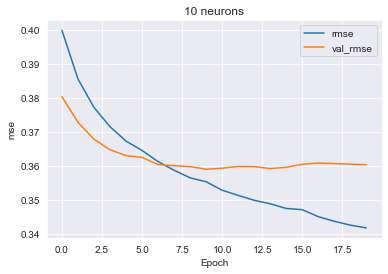

14/14 [==============================] - 0s 883us/step
MAE Train =     0.26152259294545815
RMSE Train =    0.33975585110470735
R2 =            0.13813316493709948

8/8 [==============================] - 0s 1ms/step
MAE Test =      0.2772480071355522
RMSE Test =     0.3603554015397843
R2 =            -0.003264916509930993


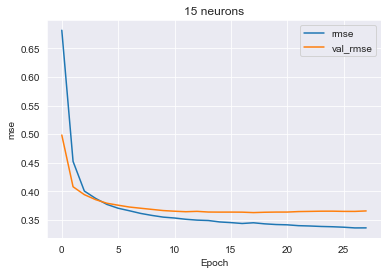

14/14 [==============================] - 0s 3ms/step
MAE Train =     0.25300361179189595
RMSE Train =    0.33334784557993535
R2 =            0.1703372624578956

8/8 [==============================] - 0s 837us/step
MAE Test =      0.28215017483707217
RMSE Test =     0.36570551677143215
R2 =            -0.03327655798101681


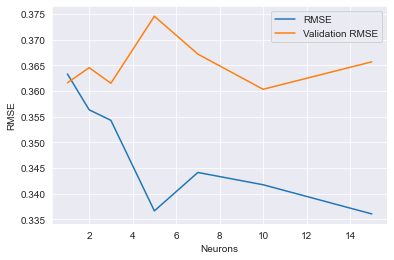

In [93]:
# Define the loss plot
def plot_loss(history):
    plt.plot(history.history['root_mean_squared_error'], label='rmse')
    plt.plot(history.history['val_root_mean_squared_error'], label='val_rmse')
    # plt.ylim([0, y_lim])
    plt.xlabel('Epoch')
    plt.ylabel('mse')
    plt.legend()
    plt.title(f"{num_neurons} neurons")

    plt.grid(True)
    plt.show()


from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization

#setup normalizer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

number_of_inputs = X_train.shape[1]

# sweep neurons
mse_list = []
val_mse_list = []

neurons_to_try = [1, 2, 3, 5, 7, 10, 15]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

for num_neurons in neurons_to_try:

    #---- pasted in model
    model = keras.Sequential([normalizer,
                            layers.Dense(num_neurons, activation='relu', input_dim=number_of_inputs),
                            layers.Dense(num_neurons, activation='sigmoid'),
                            layers.Dense(1, activation='linear') ])

    model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

    history = model.fit(X_train, y_train,
                        epochs=200,
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        callbacks=[callback],
                        verbose=0)  # Calculate validation results on 35% of the training data

    # Isolate the metric for each epoch.
    hist = pd.DataFrame(history.history)

    #---- end model paste

    # record metrics

    current_mse = hist['root_mean_squared_error']
    current_mse = current_mse[len(current_mse)-1]  # last element is the final value
    mse_list.append(current_mse)

    current_val_mse = hist['val_root_mean_squared_error']
    current_val_mse = current_val_mse[len(current_val_mse)-1] #  last element is the final value
    val_mse_list.append(current_val_mse)

    plot_loss(history)

    # calculate metrics ---------------
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score

    # train
    y_pred_train = model.predict(X_train)
    print(f"MAE Train =     {mean_absolute_error(y_train, y_pred_train)}")
    print(f"RMSE Train =    {mean_squared_error(y_train, y_pred_train, squared=False)}")
    print(f"R2 =            {r2_score(y_train, y_pred_train)}")
    print(f"")

    # holdout
    y_pred_test = model.predict(X_test)
    print(f"MAE Test =      {mean_absolute_error(y_test, y_pred_test)}")
    print(f"RMSE Test =     {mean_squared_error(y_test, y_pred_test, squared=False)}")
    print(f"R2 =            {r2_score(y_test, y_pred_test)}")

#plot results of sweep
plt.plot(neurons_to_try, mse_list, label='RMSE')
plt.plot(neurons_to_try, val_mse_list, label='Validation RMSE')

# plt.ylim([1,y_lim])
plt.xlabel('Neurons')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

#### Final model on Fastball only


In [94]:
# try groupby pitch_type
# convert pitch dummies to single column
org_pit_col_train = pd.from_dummies(X[['pitch_type_CH', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF',
                                       'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL']],
                                    sep='pitch_type_')
# drop dummy pitch_types from transformed train set
X_grp_pit = X.drop(
    columns=['pitch_type_CH', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC',
             'pitch_type_SI', 'pitch_type_SL'], axis=1)
# # add back zipped column, need to use .values attribute or will have index issues
X_grp_pit['pitch_type'] = org_pit_col_train.values
# # groupby pitch_type
X_ff = X_grp_pit.groupby(['pitch_type']).get_group('FF')
X_ff = X_ff.drop(columns=['pitch_type'])
y = marte_vs.groupby(['pitch_type']).get_group('FF').xwOBA
X_train, X_test, y_train, y_test = train_test_split(X_ff, y, test_size=0.35, random_state=1642)

print('Train set shape\n', X_train.shape, y_train.shape)
print('Test set shape\n', X_test.shape, y_test.shape)
print('---')
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

num_feats = ['release_speed', 'release_spin_rate', 'pfx_v', 'pfx_x', 'pfx_z']
# used for positive values
pt = PowerTransformer()
nct = ColumnTransformer(
    transformers=[
        ('pt_pre', pt, num_feats)
    ])

# get a transformed series of numerical features
X_train_trx = pt.fit_transform(X_train[num_feats])
# overwrite raw numerical data
X_train[num_feats] = X_train_trx

# transform the test set with the trained lambdas
X_test_trx = pt.transform(X_test[num_feats])
# overwrite raw numerical dataframe
X_test[num_feats] = X_test_trx
############################
# # normalize output
# mms = MinMaxScaler().fit(y_train.to_numpy().reshape(-1, 1))
# y_train_trx = pd.Series(map(lambda x: x[0], mms.transform(y_train.to_numpy().reshape(-1, 1))), index=y_train.index)
# # normalize on the test output, converted to a pandas.Series with the original indicies
# y_test_trx = pd.Series(map(lambda x: x[0], mms.transform(y_test.to_numpy().reshape(-1, 1))), index=y_test.index)


print('Train trx set shape\n', X_train_trx.shape, y_train.shape)
print('Test trx set shape\n', X_test_trx.shape, y_test.shape)

Train set shape
 (177, 20) (177,)
Test set shape
 (96, 20) (96,)
---
Train trx set shape
 (177, 5) (177,)
Test trx set shape
 (96, 5) (96,)


In [106]:
#setup normalizer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

model = keras.Sequential([normalizer,
                          layers.Dense(10, activation='relu', input_dim=number_of_inputs, kernel_regularizer=regularizers.l1_l2()),
                          layers.Dense(10, activation='sigmoid', kernel_regularizer=regularizers.l1_l2()),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("Fit model on training data")
history = model.fit(
    X_train,
    y_train,
    batch_size=8,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test, y_test),
    callbacks=[callback],
    verbose=0
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=8)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions")
predictions = model.predict(X_test)
print("predictions shape:", predictions.shape)

X5_rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)
print(f"rmse: {X5_rmse}")

X5_r2 = r2_score(y_true=y_test, y_pred=predictions)
print(f"r2 score: {X5_r2}")

Fit model on training data
Evaluate on test data
12/12 [==============================] - 0s 782us/step - loss: 0.1135 - root_mean_squared_error: 0.3364 - mean_absolute_error: 0.2629 - r_square: -0.0090
test loss, test acc: [0.11351730674505234, 0.33641716837882996, 0.26291021704673767, -0.009003281593322754]
Generate predictions
3/3 [==============================] - 0s 1ms/step
predictions shape: (96, 1)
rmse: 0.33641717087180917
r2 score: -0.009003235736306126
